## **Transcription speech to text (+ traduction)**

<br>

> #### &emsp; &emsp; Ce notebook contient :
>
> &emsp; Un bref rappel du contexte (utilité de l'application déployée)
>
> 1. La présentation et l'exploration du testing set
>
> 2. Notre baseline : <br> le modèle wav2vec2 pour la trancription <br>
>    (+ nllb-200-distilled-600M pour la traduction)
>
> 3. La nouvelle méthode : modèle whisper <br>
>
> 4. La comparaison des résultats des modèles text to speech, <br>
>    en évaluant (WER) la qualité des transcripts proposés par les 2 modèles <br>
>
> 5. Une évaluation plus subjective de la qualité des traductions obtenues <br>
>
> &emsp; En conclusion, une synthèse récapitulative (tableau), baseline vs nouvelle méthode <br><br>


## 0. Contexte, Imports


In [ ]:
# Les cas d'utilisation possibles d'un traducteur automatique sont très variés.
# Cet outil (de pure science-fiction il y a encore quelques années !)
# peut aider bien sûr lors d'un voyage par exemple, ou dans le cadre professionnel.
# Il permet à deux personnes ne parlant la même langue de communiquer très facilement.

# L'application déployée dans ce projet a été développée pour une situation bien précise :
# Il s'agit de répondre aux besoin d'un restaurant situé dans une zone touristique...
# et se préparant de plus à l'approche des jeux olympiques.


# Cela nous donne des objectifs précis.
# Voici les points soulignés par la cliente, gérante du restaurant :

# détection auto
# Imaginons qu'un client se présente, mais personne ne le comprend.
# Pire, personne ne parvient à identifier avec certitude la langue qu'il parle.
# C'est la première chose que notre modèle doit être capable de faire,
# détecter automatiquement la langue.

# bruit
# L'environnement d'un restaurant n'est pas du tout idéal, car il y a généralement un fonds sonore.
# Le modèle devra donc autant que possible être robuste à un certain niveau de bruit.

# rapidité
# Le service d'un restaurant comporte souvent des "rushs" où il est essentiel pour l'équipe
# d'être très efficace, pour apporter les repas aussi vite que possible.
# Le modèle déployé doit donc être suffisant rapide, ici cela a réelle importance.
# Impossible d'attendre une taduction pendant une minute.
# Il faut avoir une réponse de qualité, en quelques secondes.

# confidentialité / sécurité
# La gérante souhaite être certaine que la confidentialité des clients est assurée.
# Pour cette raison, plutôt que d'utiliser une API, nous allons importer les modèles.
# L'appli est déployée sur le cloud avec streamlit, mais le restaurant utilise une version
# totalement locale, où rien n'est uploadé.
# On peut vérifier dans le code (app_rosetta.py) que l'enregistrement audio n'est jamais
# sauvegardé, il s'agit d'un fichier temporaire.
# Cela nous amène au dernier point :

# hors-connexion
# Le restaurant souhaite que l'outil fonctionne hors connexion, en cas de coupure du réseau
# ou éventuelle coupure électrique (très rare, mais peut se produire)
# Ils utiliseront donc la version locale, qui a servi au déployement,
# et qui fonctionne sans problème, connexion ou pas.

# facilité d'utilisation


### 0.1 Librairies, réglages


In [29]:
# paths, folders/files
import os, sys, random
from glob import glob
import re


# test : un module (openCV) est difficile à trouver ds les répos conda standards.
# On veut l'installer ds l'env local, pas dans la base (de préférence, pas très grave au pire.)
# -> Check if CONDA_DEFAULT_ENV is set
if 'CONDA_DEFAULT_ENV' in os.environ:
    current_env = os.environ['CONDA_DEFAULT_ENV']
    print(f"Current conda environment: {current_env}")
else: # OK never reached, le notebook charge forcement un env dans le kernel avant d'executer la 1ere cell
    print("No conda environment is activated.")
    %conda activate env_p6 # nom de l'environnement local


# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
# from collections import Counter


# Visualisation
from pprint import pprint
import matplotlib as matplot
import matplotlib.pyplot as plt
from matplotlib.image import imread
# import seaborn as sns
import plotly.express as px
# from PIL import Image, ImageOps #, ImageEnhance


# Feature engineering
from sklearn import preprocessing

try:
    import librosa
except:
    print('Installing librosa...')
    %pip install librosa
    print('done')
    import librosa

import IPython.display as ipd
import librosa.display
from scipy.io import wavfile as wav

try:
    from pydub import AudioSegment
    from pydub.playback import play
except:
    print('Installing pydub...')
    %pip install --upgrade pydub
    print('done')
    from pydub import AudioSegment
    from pydub.playback import play

try:
    import torch
except:
    print('Installing pytorch...')
    %pip install --upgrade torch
    print('done')
    import torch

import transformers
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

try:
    from tqdm.auto import tqdm
except:
    %pip install tqdm
    from tqdm.auto import tqdm

%env TOKENIZERS_PARALLELISM=true
device = torch.device('cuda')

try:
    import whisper
except:
    print('Installing whisper...')
    %pip install git+https://github.com/openai/whisper.git
    print('done')
    import whisper

import pickle


print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('librosa version ' + librosa.__version__)
print('plt version ' + matplot.__version__) # 3.7 pour compatibilité avec librosa.display.waveshow
print('transformers ' + transformers.__version__) # > 4.3 ? ok

# plt.style.use('ggplot')
pd.set_option('display.max_rows', 200)


# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=7)


Current conda environment: myenv_p7
env: TOKENIZERS_PARALLELISM=true

Python version 3.11.8 (main, Feb 26 2024, 21:39:34) [GCC 11.2.0]
pandas version 2.2.1
librosa version 0.10.1
plt version 3.7.2
transformers 4.37.2

Number of CPU cores: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 fonctions


In [30]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))

### 0.3 Variables globales


In [31]:
size_test = 1
model_type = 'small' # tiny, base, small, medium, large


In [32]:
# test

languages = [ # 98 total but these have wer accuracy > 50% which is an industry standard benchmark
    'Afrikaans', 'Arabic', 'Armenian', 'Azerbaijani', 'Belarusian', 'Bosnian', 'Bulgarian', 'Catalan', 'Chinese',
    'Croatian', 'Czech', 'Danish', 'Dutch', 'English', 'Estonian', 'Finnish', 'French', 'Galician', 'German', 'Greek',
    'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Kannada', 'Kazakh', 'Korean',
    'Latvian', 'Lithuanian', 'Macedonian', 'Malay', 'Marathi', 'Maori', 'Nepali', 'Norwegian', 'Persian', 'Polish',
    'Portuguese', 'Romanian', 'Russian', 'Serbian', 'Slovak', 'Slovenian', 'Spanish', 'Swahili', 'Swedish', 'Tagalog',
    'Tamil', 'Thai', 'Turkish', 'Ukrainian', 'Urdu', 'Vietnamese', 'Welsh'
]
len(languages)


57

## 1 Exploration et préparation des données


### 1.1 Infos générales sur le dataset


In [33]:
raw_data = pd.read_csv(f'./data/mls_french_opus/metainfo.txt', sep='|')

quick_look(raw_data)


shape : (4960, 7)


,SPEAKER,GENDER,PARTITION,MINUTES,BOOK ID,TITLE,CHAPTER
0,10065,M,train,9.002,10039,Saint Évangile selon Saint Marc,Chapitre 09
1,10065,M,train,9.845,10039,Saint Évangile selon Saint Marc,Chapitre 06
2,10065,M,train,6.503,10039,Saint Évangile selon Saint Marc,Chapitre 15
3,10065,M,train,6.788,10039,Saint Évangile selon Saint Marc,Chapitre 05
4,10065,M,train,5.059,10039,Saint Évangile selon Saint Marc,Chapitre 02


,SPEAKER,GENDER,PARTITION,MINUTES,BOOK ID,TITLE,CHAPTER
4955,9834,M,test,6.681,9697,Zadig ou la destinée,Chapitre VII. Les disputes et les audiences
4956,9834,M,test,7.779,9697,Zadig ou la destinée,Chapitre IV. L'envieux
4957,9834,M,test,7.573,9697,Zadig ou la destinée,Chapitre I. Le borgne
4958,9834,M,test,2.995,9697,Zadig ou la destinée,Chapitre II. Le nez
4959,9834,M,test,3.237,9697,Zadig ou la destinée,Chapitre V. Les généreux


uniques :


 SPEAKER                            178
  GENDER                              2
PARTITION                             3
 MINUTES                           4530
 BOOK ID                            160
            TITLE                   160
           CHAPTER                 4620
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
SPEAKER,SPEAKER,0,4960,0.0,int64
GENDER,GENDER,0,4960,0.0,object
PARTITION,PARTITION,0,4960,0.0,object
MINUTES,MINUTES,0,4960,0.0,float64
BOOK ID,BOOK ID,0,4960,0.0,int64
TITLE,TITLE,0,4960,0.0,object
CHAPTER,CHAPTER,0,4960,0.0,object


In [34]:
# On veut partition test uniquement

# data = raw_data.loc[raw_data['PARTITION'] == 'test', :].copy()

# 'PARTITION' n'existe pas ??


In [35]:
# Print the names of all columns
print(raw_data.columns)

# OK...


Index(['  SPEAKER   ', '   GENDER   ', ' PARTITION  ', '  MINUTES   ',
       '  BOOK ID   ', '             TITLE              ',
       '            CHAPTER            '],
      dtype='object')


In [36]:
raw_data.columns = [col.lower().strip() for col in raw_data.columns]

print(raw_data.columns)


Index(['speaker', 'gender', 'partition', 'minutes', 'book id', 'title',
       'chapter'],
      dtype='object')


In [37]:
data = raw_data.loc[raw_data['partition'] == 'test', :].copy()

print(data.shape)
data.head()

# J'imagine que c'est le mm problème.


(0, 7)


,speaker,gender,partition,minutes,book id,title,chapter


In [38]:
print(raw_data['speaker'][0])
display(raw_data.loc[raw_data['speaker'] == 10065].head())

# ça fonctionne pour le lecteur / la lectrice


10065


,speaker,gender,partition,minutes,book id,title,chapter
0,10065,M,train,9.002,10039,Saint Évangile selon Saint Marc,Chapitre 09
1,10065,M,train,9.845,10039,Saint Évangile selon Saint Marc,Chapitre 06
2,10065,M,train,6.503,10039,Saint Évangile selon Saint Marc,Chapitre 15
3,10065,M,train,6.788,10039,Saint Évangile selon Saint Marc,Chapitre 05
4,10065,M,train,5.059,10039,Saint Évangile selon Saint Marc,Chapitre 02


In [39]:
print(raw_data['partition'][0])
print(raw_data['partition'][4959])

raw_data['partition'] = raw_data['partition'].apply(
    lambda x: x.strip())

print(raw_data['partition'][0])
print(raw_data['partition'][4959])

# ok


   train    
    test    
train
test


### 1.2 test partition


In [40]:
data = raw_data.loc[raw_data['partition'] == 'test', :].copy()

print(data.shape)
data.head()


(95, 7)


,speaker,gender,partition,minutes,book id,title,chapter
4865,1406,M,test,6.995,1028,"Mille et une nuits, tome 1",010 - Dixième nuit
4866,1406,M,test,4.992,1028,"Mille et une nuits, tome 1",009 - Neuvième nuit
4867,1406,M,test,3.554,1028,"Mille et une nuits, tome 1",008 - Huitième nuit. Histoire du pêcheur
4868,1406,M,test,1.734,1417,À se tordre,Le pendu bienveillant
4869,1406,M,test,7.491,1417,À se tordre,Esthetic


### 1.3 Transcripts


In [41]:
transcripts = pd.read_csv(f'./data/mls_french_opus/test/transcripts.txt', sep='\t', header=None)

quick_look(transcripts)

# uniques ? 0 doublon ? checker
# en fait c juste ca qu il nous faut pour eval modele
# just turn 0 into path
# and add model prediction


shape : (2426, 2)


,0,1
0,1406_1028_000000,pendant le second siècle je fis serment d'ouvr...
1,1406_1028_000001,non ta mort est certaine dit le génie choisis ...
2,1406_1028_000002,la nuit suivante appela sa soeur quand il en f...
3,1406_1028_000003,à l'aspect d'un monstre d'une grandeur si déme...
4,1406_1028_000004,le sultan qui n'avait pas moins d'envie que di...


,0,1
2421,9834_9697_000156,par les plus grands forfaits sur le trône affe...
2422,9834_9697_000157,il parla avec tant de grâce d'esprit et de rai...
2423,9834_9697_000158,quand tu manges donne à manger aux chiens duss...
2424,9834_9697_000159,d'autres traces en un sens différent qui parai...
2425,9834_9697_000160,à ce vain bruit de paroles qu'on appelait conv...


uniques :


0    2426
1    2425
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
0,0,0,2426,0.0,object
1,1,0,2426,0.0,object


### 1.4 Test sample


In [42]:
# encore bcp trop long (1 prediction peut prendre 1 min)

test_data = transcripts.sample(n=size_test, random_state=42)
test_data.reset_index(inplace=True)

quick_look(test_data)


shape : (1, 3)


,index,0,1
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...


,index,0,1
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...


uniques :


index    1
0        1
1        1
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
index,index,0,1,0.0,int64
0,0,0,1,0.0,object
1,1,0,1,0.0,object


### 1.5 Adresses


In [43]:
def id_into_path(file_name):
    # Split the file name into parts
    parts = file_name.split('_')

    # Create the path using the parts
    path = f'./data/mls_french_opus/test/audio/{parts[0]}/{parts[1]}/{file_name}.opus'

    return path


test_data['path'] = test_data[0].apply(id_into_path)

test_data.head()


,index,0,1,path
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...


### 1.6 Clean true transcript


In [44]:
test_data[1] = test_data[1].apply(
    lambda x: x.strip())

test_data.head()

# ?


,index,0,1,path
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...


### 1.7 EDA


In [45]:
# describe nb mots ? / len ?
# autre ? h / f ?


In [46]:
# Observons qq transcripts

max_exemples = 10

for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, [1]].values[0], '\n')

# Pas de majuscules
# Pas de ponctuation, sauf apostrophes et tirets


0 

Texte d'origine :
["blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale"] 



## 2 Baseline


In [47]:
# https://www.kaggle.com/code/stpeteishii/french-audio-wav2vec2-translation


Intro du notebook servant de baseline, présentation du modèle de transcription :

"facebook/wav2vec2-large-xlsr-53-french
The facebook/wav2vec2-large-xlsr-53-french model is a pre-trained speech recognition model that is specifically trained on French audio data. It is based on the Wav2Vec2 architecture, which is a transformer-based model that has been shown to be very effective for speech recognition tasks.

The facebook/wav2vec2-large-xlsr-53-french model is trained on a dataset of over 14,000 hours of French audio data. This data includes a variety of different speakers, recording conditions, and dialects. The model is also fine-tuned on a smaller dataset of manually transcribed French audio data.

Présentation du modèle utilisé pour la traduction :

facebook/nllb-200-distilled-600M
facebook/nllb-200-distilled-600M is a machine translation model from Facebook AI that can translate between 200 languages. It is a distilled version of the larger facebook/nllb-200-1.3B model, which was trained on a massive dataset of text and code. The distilled model is smaller and faster, but it still achieves state-of-the-art performance on translation tasks."


In [48]:
# Well, there is already a new state of the art.


### 2.1 Wav2Vec2


In [49]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/home/ubuntu/anaconda3/envs/myenv_p7/lib/python3.11/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:733: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53-french were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53-french and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should prob

In [50]:
def get_wav2vec_transcription(path):
    # Load the audio with the librosa library
    input_audio, _ = librosa.load(path, sr=16000)
    # data, sample_rate = librosa.load(file_path)
    # Tokenize the audio
    input_values = tokenizer(input_audio, return_tensors="pt", padding="longest").input_values
    # Feed it through Wav2Vec & choose the most probable tokens
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
    # Decode & add to our caption string
    transcription = tokenizer.batch_decode(predicted_ids)[0]

    return transcription


pandarallel.initialize(progress_bar=True, nb_workers=8)

test_data['baseline'] = test_data['path'].apply(get_wav2vec_transcription) # parallel_apply ?

test_data.head()


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,index,0,1,path,baseline
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et milliare sortirent également le gou...


## 3 Nouvelle méthode


In [51]:
model_path = f'./data/whisper_{model_type}.pkl' # ??

model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded") # small ou medium
# 461 M
# 1 G avec pickle ??


In [52]:
with open(model_path, 'wb') as f:
    # pickle.dump(model, f)
    pass

In [53]:
file_path = './data/mls_french_opus/test/audio/2085/1565/2085_1565_000000.opus'

#Loading
audio_test = whisper.load_audio(file_path)
audio_test


array([-2.3345947e-02, -2.0599365e-02, -2.1789551e-02, ...,
        9.1552734e-05, -2.2277832e-03,  1.1901855e-03], dtype=float32)

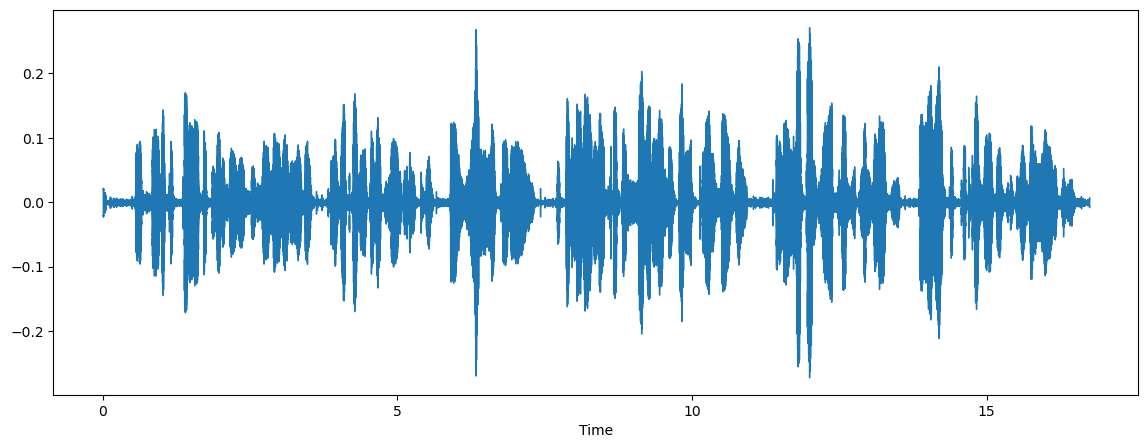

In [54]:
#

plt.figure(figsize=(14,5))

data, sample_rate = librosa.load(file_path)

librosa.display.waveshow(data,sr=sample_rate)


In [55]:
%pip install soundfile sounddevice

import soundfile as sf
import sounddevice as sd

def play_opus(file_path):
    # Load the Opus file
    audio_data, sample_rate = sf.read(file_path)

    # Play the audio
    sd.play(audio_data, sample_rate)
    sd.wait()


play_opus(file_path) # randomiser !!


Note: you may need to restart the kernel to use updated packages.


In [56]:
# ipd.Audio(file_path) # nope need to convert .opus to .wav or other compatible codec


In [57]:
sample_rate # default librosa (donc standardisé)


22050

In [58]:
# wave_sample_rate, wave_audio = wav.read(file_path)
# wave_sample_rate # original


In [59]:
audio = whisper.pad_or_trim(audio_test)

#Number of samples in our trimmed/padded audio
n_samples =  audio.shape[-1]
n_samples

#Time of each sample
# time = np.linspace(0,(n_samples-1)*delta,n_samples)


480000

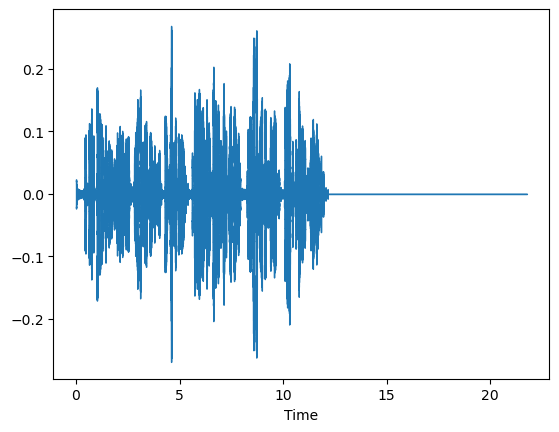

In [60]:
librosa.display.waveshow(audio,sr=sample_rate)


In [61]:
mel = whisper.log_mel_spectrogram(audio).to(model.device)


In [62]:
if model_type != 'large':
    probs = model.detect_language(mel)
    print(len(list(probs[1])))
    probs[1]


99


In [63]:
if model_type != 'large':

    # Sort the dictionary based on predicted probabilities in descending order
    sorted_dict_probs = dict(sorted(probs[1].items(), key=lambda item: item[1], reverse=True))

    for langage, proba in list(sorted_dict_probs.items())[:1]:
        print(f'Langage détecté : {langage} ({proba}%)')

    transcription = model.transcribe(file_path, fp16 = False)['text']
    transcription

# wow


Langage détecté : fr (0.986860454082489%)


### Prédictions sur testing set


In [64]:
def get_whisper_transcription(path):
    # syntaxe + courte !
    transcription = model.transcribe(path, fp16 = False)['text']

    return transcription


# pandarallel.initialize(progress_bar=True, nb_workers=8)

test_data['new'] = test_data['path'].apply(get_whisper_transcription) # parallel_apply ?

test_data.head()

# bcp + long, environ 6x
# (3 min pour whisper medium, contre 20s pour wav2vec2, sur 5 transcriptions

# Prend aussi + de ressources
# (presque 3 Go de + sur la RAM)

# Les performances sont-elles à la hauteur ?
# Déjà, on a la ponctuation !
# ... ce qui va par ailleurs compliquer l'évaluation...


,index,0,1,path,baseline,new
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et milliare sortirent également le gou...,Blanqui et Miliaire sortirent également. Le g...


In [65]:
# Un peu dommage d'avoir à faire ça

def remove_punctuation(string):
    # remove_punctuation using regex + lower
    string = re.sub(r'[^\w\s\'\-]', '', string).lower().strip()

    return string


test_data['new_no_punct'] = test_data['new'].apply(remove_punctuation)

test_data.head()

# J'ai appris par la suite que Whisper possède sa propre méthode de normalisation
# (= ce qu'on a fait, lowering + ponctuation removal)


,index,0,1,path,baseline,new,new_no_punct
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et milliare sortirent également le gou...,Blanqui et Miliaire sortirent également. Le g...,blanqui et miliaire sortirent également le gou...


## 4 Comparaison


In [66]:
for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, [1]].values[0][0], '\n')

    print('Transcript wav2vec2 :')
    print(test_data.loc[test_data.index == index, ['baseline']].values[0][0], '\n')

    print('Transcript whisper :')
    print(test_data.loc[test_data.index == index, ['new']].values[0][0], '\n')

    print('Transcript whisper (no punct) :')
    print(test_data.loc[test_data.index == index, ['new_no_punct']].values[0][0], '\n')

# seems ok


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript whisper :
 Blanqui et Miliaire sortirent également. Le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée. Le soir même du 31 octobre avait lieu à la Bourse une réunion des officiers de la Garde nationale 

Transcript whisper (no punct) :
blanqui et miliaire sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du 31 octobre avait lieu à la bourse une réunion des officiers de la garde nationale 



### 4.1 Metrique


In [67]:
# métrique :
# https://www.kaggle.com/code/kevinvaishnav/speechtotext

def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    #print(ref_words, hyp_words)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


In [74]:
# exemples

print(_levenshtein_distance('abc', 'abcd')) # 1 transformation nécessaire (ajouter character d)
print(_levenshtein_distance('abc', 'ABC'), '\n') # Sensible à la casse !

print(wer('Ils sont partis', 'ils sont parti')) # taux = 2 erreurs / 3 mots (env 0.67)
print(wer('Ils sont partis', 'i sont pati')) # Compte une erreur max par mot

# Le wer ressemble aux règles utilisées pour noter une dictée à l'école.
# Il ne fait pas la différence entre une "petite erreur", par exemple un accent,
# et un mot complet mal transcrit.

# Du coup, quand +ieurs orthographes sont acceptées, c'est le transcript de référence qui compte.
# Par exemple si 2 orthographes sont possibles, le modèle a 1 chance sur 2 de renvoyer la "bonne".

# Cete métrique n'est donc pas parfaitement juste et objective, comme le sont un r2, une rmse, l'accuracy, etc...
# Elle nous permet cependant d'évaluer et de comparer nos modèles, àcondition de l'utiliser
# sur un testing set suffisamment important pour corriger ces aléas statistiques.


1
3 

0.6666666666666666
0.6666666666666666


### Eval


In [38]:
liste_wer_wav2vec = []
liste_wer_whisper = []

for index in test_data.index:
    print(f'{index}', '\n')

    df = test_data.loc[test_data.index == index, :]

    print('Texte d\'origine :')
    txt_origin = df[[1]].values[0][0]
    print(txt_origin, '\n')

    print('Transcript wav2vec2 :')
    transcript_baseline = df[['baseline']].values[0][0]
    print(transcript_baseline)

    wer_baseline = wer(txt_origin, transcript_baseline)
    print(wer_baseline, '\n')
    liste_wer_wav2vec.append(wer_baseline)

    print('Transcript whisper :')
    print(df[['new']].values[0][0], '\n')

    print('Transcript whisper (no punct) :')
    transcript_new_clean = df[['new_no_punct']].values[0][0]
    print(transcript_new_clean)

    wer_new = wer(txt_origin, transcript_new_clean)
    print(wer_new, '\n')
    liste_wer_whisper.append(wer_new)


# moyennes
mean_wer_baseline = np.mean(liste_wer_wav2vec)
mean_wer_new = np.mean(liste_wer_whisper)

print(mean_wer_baseline)
print(mean_wer_new)

# Serré !
# whisper medium > wav2vec2 > whisper small
# (proche, différence environ 1%)

# whisper base bcp + rapide, mais fait 2x + d'erreurs

# tracker tps pred moy

# whisper large
# bcp + long (1 min par pred en moyenne)
# mais les résultats sont impressionnants !


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale
0.11428571428571428 

Transcript whisper :
 blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript whisper (no punct) :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
0.0 

1 

Texte d'origine :
il n'e

: 

## Bonus : traduction


In [190]:
translation = model.transcribe(file_path, language = 'en', fp16 = False)['text']
translation

# marrant
# pas parfait mais excellent. a corrigé "verris"


' My brother was so absorbed in his chemical visions that he represented the action with his foot, as if it were real to him. And unfortunately he hit his basket full of glass so hard that he threw it from the top of his street shop, so that all the glass was broken into a thousand pieces.'

In [191]:
translation = model.transcribe(file_path, language = 'ja', fp16 = False)['text']
translation

# ??


'同大から見するための自信に 行われてた。最近のραismusはとても多いだけだ。あなたが秩序中のランナーだと証拠 backo такое、ニually recording and video editingが deepening your memorygives you the opportunityお想いです。'

## done


In [192]:
# eval


## Conclusion


In [193]:
# Les modèles comme word2vec, construits
